# Lab Five: Data Science Salary Analysis

***Md Mahfuzur Rahman, Will Schneider, Nik Zelenikovski***



In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_auc_score, roc_curve

from tensorflow.keras.losses import binary_crossentropy
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import sys
import matplotlib

from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras.layers import Embedding, Flatten
from matplotlib import pyplot as plt

from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from copy import deepcopy
import sys
import os
import warnings
warnings.filterwarnings('ignore')


from scipy.special import expit

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## 1.1 Data Preparation

### 1.1.1 Define and Prepare Class Variables:

During the initial inspection process, we import the data and look for duplicates and missing values. Here's how the dataset and variables are prepared:

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

df = pd.read_csv('salaries.csv') # read in the csv file


print(df.info())
print('===========')
# note that the describe function defaults to using only some variables
print(df.describe())
print('===========')

print(df.select_dtypes(include=['object']).nunique().sum(),"unique class variables")
print('===========')

df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print(df.shape)

# create a data description table
data_des = pd.DataFrame()
#code adapted from sample Lab 1 Submission
data_des['Features'] = df.columns
data_des['Description'] = ['Work Year', 'Position Experience Level',
                          'Employment Type', 'Job Title',
                          'Position Salary', 'Currency of Salary',
                          'Position Salary (USD)', 'Employee Residence',
                          'Percentage of Job Responsibilities Completed Remotely', 'Company Location', 'Company Size']
data_des['Scales'] = ['interval'] + ['ordinal'] + ['nominal']*2 + ['ratio'] + ['nominal']+ ['ratio'] + ['nominal'] + ['ratio'] + ['nominal'] + ['ordinal']
data_des['Discrete\Continuous'] = ['continuous'] + ['discrete']*3 + ['continuous'] + \
                                  ['discrete'] + ['continuous'] + ['discrete'] + ['continuous'] + ['discrete']*2
data_des['Unique Values'] = df[df.columns].nunique().values
data_des

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23710 entries, 0 to 23709
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           23710 non-null  int64 
 1   experience_level    23710 non-null  object
 2   employment_type     23710 non-null  object
 3   job_title           23710 non-null  object
 4   salary              23710 non-null  int64 
 5   salary_currency     23710 non-null  object
 6   salary_in_usd       23710 non-null  int64 
 7   employee_residence  23710 non-null  object
 8   remote_ratio        23710 non-null  int64 
 9   company_location    23710 non-null  object
 10  company_size        23710 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.0+ MB
None
          work_year        salary  salary_in_usd  remote_ratio
count  23710.000000  2.371000e+04   23710.000000  23710.000000
mean    2023.460565  1.618500e+05  151918.919823     27.954450
std        0.693803  2.

,Features,Description,Scales,Discrete\Continuous,Unique Values
0,work_year,Work Year,interval,continuous,5
1,experience_level,Position Experience Level,ordinal,discrete,4
2,employment_type,Employment Type,nominal,discrete,4
3,job_title,Job Title,nominal,discrete,169
4,salary,Position Salary,ratio,continuous,3400
5,salary_currency,Currency of Salary,nominal,discrete,24
6,salary_in_usd,Position Salary (USD),ratio,continuous,3804
7,employee_residence,Employee Residence,nominal,discrete,89
8,remote_ratio,Percentage of Job Responsibilities Completed R...,ratio,continuous,3
9,company_location,Company Location,nominal,discrete,78


### 1.1.2. Variable Representation and Preprocessing
Next, we encode category variables, scale numerical features, and reduce dimensionality as needed.


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encoding categorical features
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Scaling numerical features
scaler = StandardScaler()
numerical_features = df.select_dtypes(include=[np.number]).columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print(df.head())


   work_year  experience_level  employment_type  job_title    salary  \
0   0.757201          0.704461         0.029147  -0.745023 -0.298097   
1   0.757201         -2.443823         0.029147  -0.745023 -0.202676   
2   0.757201         -0.344967         0.029147   1.245163  0.310956   
3   0.757201         -0.344967         0.029147   1.245163  0.178585   
4   0.757201         -0.344967         0.029147   1.245163  0.141901   

   salary_currency  salary_in_usd  employee_residence  remote_ratio  \
0         0.307398      -1.302681            0.317209      1.461305   
1         0.307398      -0.807564            0.410276      1.461305   
2         0.307398       1.857537            0.410276     -0.699298   
3         0.307398       1.170701            0.410276     -0.699298   
4         0.307398       0.980356            0.410276     -0.699298   

   company_location  company_size  
0         -0.322948     -3.767512  
1          0.407029      0.146215  
2          0.407029      0.14621

### 1.1.3. Eliminating unnecessary variables
Based on the findings, we may eliminate variables that are ineffective for our classification or regression tasks. For example, if Currency of Salary does not provide value to the model, it might be eliminated.


In [4]:
# Removing unnecessary columns
df = df.drop(['work_year'], axis=1)

print(df.head())


   experience_level  employment_type  job_title    salary  salary_currency  \
0          0.704461         0.029147  -0.745023 -0.298097         0.307398   
1         -2.443823         0.029147  -0.745023 -0.202676         0.307398   
2         -0.344967         0.029147   1.245163  0.310956         0.307398   
3         -0.344967         0.029147   1.245163  0.178585         0.307398   
4         -0.344967         0.029147   1.245163  0.141901         0.307398   

   salary_in_usd  employee_residence  remote_ratio  company_location  \
0      -1.302681            0.317209      1.461305         -0.322948   
1      -0.807564            0.410276      1.461305          0.407029   
2       1.857537            0.410276     -0.699298          0.407029   
3       1.170701            0.410276     -0.699298          0.407029   
4       0.980356            0.410276     -0.699298          0.407029   

   company_size  
0     -3.767512  
1      0.146215  
2      0.146215  
3      0.146215  
4      0

### 1.1.4. Description of the Final Dataset.
The finished dataset contains encoded and scaled features suitable for classification or regression analysis.


In [5]:
print("Final dataset used for classification/regression:")
print(df.head())


Final dataset used for classification/regression:
   experience_level  employment_type  job_title    salary  salary_currency  \
0          0.704461         0.029147  -0.745023 -0.298097         0.307398   
1         -2.443823         0.029147  -0.745023 -0.202676         0.307398   
2         -0.344967         0.029147   1.245163  0.310956         0.307398   
3         -0.344967         0.029147   1.245163  0.178585         0.307398   
4         -0.344967         0.029147   1.245163  0.141901         0.307398   

   salary_in_usd  employee_residence  remote_ratio  company_location  \
0      -1.302681            0.317209      1.461305         -0.322948   
1      -0.807564            0.410276      1.461305          0.407029   
2       1.857537            0.410276     -0.699298          0.407029   
3       1.170701            0.410276     -0.699298          0.407029   
4       0.980356            0.410276     -0.699298          0.407029   

   company_size  
0     -3.767512  
1      0.146

In [6]:
# Check for missing values
print(df.isnull().sum())

experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [7]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [8]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns


In [9]:
# Assuming 'salary' is the target variable
X = df.drop('salary', axis=1).values
y = df['salary'].values


### Class Variable Definition and Dataset Preparation for Classification/Regression

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.

#### Class Variables
This dataset has 8 features with class variables. Three of the features have n > 20 unique classes, which will be reduced through embedding later in this notebook. 'remote_ratio' is a numeric feature with three values in the dataset indicating the percentage of remote work. The available values are 0, 50, 100. The data source considers these values labeled (0: Non-Remote, Hybrid, & Fully Remote. These will be converted to categorical features in the code below. A  description of all the datatypes is in the code output below. In total, the 371 unique classes exist within categorical features. These will need to be processed for dimensionality reduction and embedding into the model. Additionally, two of the categorical features resemble ordinality, even expressed in the name of the features 'company_**size**' & 'experience_**level**'. They also have low cardinality. These will be converted to labeled variables and they will be crossed with other categorical columns later in this notebook.

In [10]:
# Summary statistics after preprocessing
summary_stats = pd.DataFrame(df, columns=numerical_cols).describe()
print(summary_stats)


       experience_level  employment_type     job_title        salary  \
count      1.343700e+04     1.343700e+04  1.343700e+04  1.343700e+04   
mean      -3.384292e-17    -3.130470e-16  8.672249e-17 -2.115183e-17   
std        1.000037e+00     1.000037e+00  1.000037e+00  1.000037e+00   
min       -2.443823e+00    -1.628971e+01 -2.007092e+00 -4.041211e-01   
25%       -3.449671e-01     2.914733e-02 -7.450233e-01 -1.847845e-01   
50%        7.044608e-01     2.914733e-02 -2.838826e-01 -7.014635e-02   
75%        7.044608e-01     2.914733e-02  3.714225e-01  6.344356e-02   
max        7.044608e-01     8.188578e+00  2.070362e+00  8.013681e+01   

       salary_currency  salary_in_usd  employee_residence  remote_ratio  \
count     1.343700e+04   1.343700e+04        1.343700e+04  1.343700e+04   
mean      8.460731e-17   1.776753e-16       -3.045863e-16 -1.692146e-17   
std       1.000037e+00   1.000037e+00        1.000037e+00  1.000037e+00   
min      -4.691022e+00  -1.839057e+00       -3.5450

In [11]:
print(f"The total number of observations in the dateset is {len(df)}.")
print()
print(f"The shape of the dateset is {df.shape}.")

print('Dataframe information is:','\n')
df.info()

The total number of observations in the dateset is 13437.

The shape of the dateset is (13437, 10).
Dataframe information is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13437 entries, 0 to 13436
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   experience_level    13437 non-null  float64
 1   employment_type     13437 non-null  float64
 2   job_title           13437 non-null  float64
 3   salary              13437 non-null  float64
 4   salary_currency     13437 non-null  float64
 5   salary_in_usd       13437 non-null  float64
 6   employee_residence  13437 non-null  float64
 7   remote_ratio        13437 non-null  float64
 8   company_location    13437 non-null  float64
 9   company_size        13437 non-null  float64
dtypes: float64(10)
memory usage: 1.0 MB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
experience_level,13437.0,-3.384292e-17,1.000037,-2.443823,-0.344967,0.704461,0.704461,0.704461
employment_type,13437.0,-3.130470e-16,1.000037,-16.289715,0.029147,0.029147,0.029147,8.188578
job_title,13437.0,8.672249e-17,1.000037,-2.007092,-0.745023,-0.283883,0.371422,2.070362
salary,13437.0,-2.115183e-17,1.000037,-0.404121,-0.184785,-0.070146,0.063444,80.136810
salary_currency,13437.0,8.460731e-17,1.000037,-4.691022,0.307398,0.307398,0.307398,0.534599
salary_in_usd,13437.0,1.776753e-16,1.000037,-1.839057,-0.719378,-0.119902,0.567415,8.957231
employee_residence,13437.0,-3.045863e-16,1.000037,-3.545042,0.410276,0.410276,0.410276,0.549875
remote_ratio,13437.0,-1.692146e-17,1.000037,-0.699298,-0.699298,-0.699298,1.461305,1.461305
company_location,13437.0,7.614658e-17,1.000037,-3.503566,0.407029,0.407029,0.407029,0.511312
company_size,13437.0,8.460731e-18,1.000037,-3.767512,0.146215,0.146215,0.146215,4.059942


In [13]:
# Checking of Data Quality
total_missing_value_feature = df.isnull().sum().sort_values(ascending = False)
total_missing_value_feature

experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('salary')

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Separate target and features
X = df.drop('salary', axis=1)
y = df['salary']

# Preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
X_train = preprocessing_pipeline.fit_transform(X_train)
# Fit and transform the data
X_test = preprocessing_pipeline.fit_transform(X_test)

# Describe the final dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (10749, 9)
Shape of X_test: (2688, 9)
Shape of y_train: (10749,)
Shape of y_test: (2688,)


## 1.2: Identification of Cross-Product Features

Cross-product features (or interaction features) can capture correlations between variables that may not be apparent when the variables are studied separately. In this section, we determine feature groups to be merged and justify their decision.

Job Title and Employment Type: When these features are combined, they can give insights into how different forms of employment affect salary levels for specific job titles.

Company Location and Employee Residence: This combination can demonstrate the impact of working remotely vs on-site at various company locations.

Position Experience Level and Job Title: The relationship between experience level and job title might help you understand how experience affects remuneration in certain job roles.


In [15]:
# Creating cross-product features
df['JobTitle_EmploymentType'] = df['job_title'].astype(str) + '_' + df['employment_type'].astype(str)
df['CompanyLocation_EmployeeResidence'] = df['company_location'].astype(str) + '_' + df['employee_residence'].astype(str)
df['ExperienceLevel_JobTitle'] = df['experience_level'].astype(str) + '_' + df['job_title'].astype(str)

# Encode new cross-product features
for column in ['JobTitle_EmploymentType', 'CompanyLocation_EmployeeResidence', 'ExperienceLevel_JobTitle']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])


These characteristics should be combined because they may include useful interaction effects that increase the model's ability to predict outcomes accurately.

In [16]:
# Identify groups of features for cross-product
cross_product_features = ['job_title', 'location']

# Justification: Job titles and locations can interact to significantly impact salaries.
# For example, a software engineer in San Francisco might have a different salary compared to one in Austin.


Employee Residence x Remote Ratio
- How is the salary in USD influenced by the employee's type of salary paid? This is probably a strong indicator of pay based on area. If the pay is not in USD, it might be more of a comtract role
- Total = 9 X 4 = 36
2 Company Location x Company Size
- Companies in the US will probably be larger as it is the leading big tech country.
- Total = 9 * 3 = 27
 3 Job Title x Experience Level
- Specifics about each position (such as "Data Science Lead") suggest the experience/authority level
- Total = 13 * 4 = 52

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import FeatureSpace

# Define the feature space
feature_space1 = FeatureSpace(
    features={
        # Categorical features encoded as string
        "employment_type": FeatureSpace.string_categorical(num_oov_indices=1),
        "job_title": FeatureSpace.string_categorical(num_oov_indices=1),
        "salary_currency": FeatureSpace.string_categorical(num_oov_indices=1),
        "employee_residence": FeatureSpace.string_categorical(num_oov_indices=1),
        "company_location": FeatureSpace.string_categorical(num_oov_indices=1),

        # Categorical features encoded as integers
        "remote_ratio": FeatureSpace.integer_categorical(num_oov_indices=1),
        "company_size": FeatureSpace.integer_categorical(num_oov_indices=1),
        "experience_level": FeatureSpace.integer_categorical(num_oov_indices=1),

        # Numerical features to normalize
        "work_year": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dimension
    crosses=[
        FeatureSpace.cross(
            feature_names=('employment_type', 'company_size'),  # 8 x 3 = 24
            crossing_dim=4*3),
        FeatureSpace.cross(
            feature_names=('job_title', 'experience_level'),  # 12 x 4 = 48
            crossing_dim=12*4),
    ],
    output_mode="concat",
)

# Create TensorFlow datasets
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), dataframe))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

df = pd.read_csv('salaries.csv')
# Splitting data
X = df.drop(['salary','salary_in_usd'], axis=1)
print(X.dtypes)
y = df['salary']

# # Create the dataset
# ds_train = df_to_dataset(X, shuffle=True)
# ds_test = df_to_dataset(X, shuffle=False)

# # Create a version of the dataset that can be iterated without labels
# train_ds_with_no_labels = ds_train.map(lambda x, _: x)
# feature_space1.adapt(train_ds_with_no_labels)  # Initialize the feature map to this data

# # The adapt function allows the model to learn one-hot encoding sizes
# # Define a preprocessing operation that returns the processed features
# preproc_ds_train = ds_train.map(lambda x, y: (feature_space1(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# # Run it so that we can use the pre-processed data
# preproc_ds_train = preproc_ds_train.prefetch(tf.data.AUTOTUNE)

# # Do the same for the test set
# preproc_ds_test = ds_test.map(lambda x, y: (feature_space1(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# preproc_ds_test = preproc_ds_test.prefetch(tf.data.AUTOTUNE)

# # Example of inspecting preprocessed data
# for x, y in preproc_ds_train.take(1):
#     print("Features:", x)
#     print("Label:", y)


### Dimensionality Reduction (Square Root Heuristic)

In TensorFlow, embeddings are used to convert categorical data into continuous vector spaces, where similar categories are mapped closer together. The embedding layer in TensorFlow is a trainable layer that learns a fixed-size continuous vector representation for each category. This is especially useful for high cardinality categorical features. By choosing to embed certain classes with high cardinality, we reduced the dimensionality of the dataset. This was particularly useful in Keras, as the only real requirement is to encode the data one-hot.

From the raw data, the model has almost 25,000 parameters! That is a lot of parameters and could lead to longer computation times. To reduce dimensionality, we then passed into the TensorFlow model, and the gradient of the distances/connections of these feature-specific classes is solved, returning an output of a specified reduced size ($\sqrt{n}$) that still maintains the majority of the information from the original data. These approximations are the output of the feature space in the below code.

    *'salary_currenecy'*
- - **Number of dimensions after reduction = $\sqrt{24} \approx 4$**

    *'company_location'*
- - **Number of dimensions after reduction = $\sqrt{78} \approx 8$**

    *'employee_residence'*
- **Number of dimensions after reduction = $\sqrt{89} \approx 9$**

   *'job_title'*
- **Number of dimensions after reduction = $\sqrt{169} \approx 12$**

## 1.3: Evaluation Metrics

ROC-AUC Score (Area Under the Receiver Operating Characteristic Curve): This statistic measures the model's ability to differentiate across classes. It is especially beneficial in binary classification situations with an uneven class distribution. It compares the true positive rate to the false positive rate at different threshold values, giving a single metric to compare models.

Precision and recall: These measurements are important when the costs of false positives and false negatives differ. Precision is defined as the ratio of true positive predictions to total predicted positives, whereas recall is the ratio of true positive predictions to total real positives.

F1 Score: This is the harmonic mean of accuracy and recall, which provides a balance between the two. It is very beneficial when dealing with unbalanced data sets.

In [18]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {"ROC-AUC": roc_auc, "Precision": precision, "Recall": recall, "F1 Score": f1}


These measures are useful because they give a more nuanced picture of model performance than accuracy, especially in the presence of class imbalance and varied costs of misclassification.

In [19]:

# Justification: These metrics provide a clear indication of the prediction error in salary amounts, which is more meaningful than classification accuracy.
from sklearn.metrics import mean_absolute_error, mean_squared_error


We have selected Mean Squared Error (MSE) and Mean Absolute Error (MAE) as the best accuracy metrics to evaluate our algorithm's performance. We recognize your expertise as data scientists, machine learning engineers, and technical stakeholders, and believe that MSE and MAE offer a balanced assessment of our regression model, ensuring accurate and consistent predictions. Considering our dataset's characteristics, these metrics provide a better performance measure than relying on a single metric alone.

MSE balances the model’s precision by penalizing more significant errors, ensuring that the model minimizes substantial deviations from the actual values. This is vital for capturing the accuracy of our predictions. On the other hand, MAE offers a robust measure that treats all errors equally, providing an intuitive understanding of the model's overall prediction accuracy.

Pre-processing steps, such as scaling and encoding, are crucial for accurately calculating MSE and MAE, leading to highly reliable evaluation metrics. The selected MSE and MAE will guide the evaluation of our wide and deep networks, ensuring a balanced assessment. Effective cross-product features also enhance model performance, as reflected by these metrics.

In conclusion, MSE and MAE are the most appropriate metrics for our project as they balance the penalization of more significant errors and provide a robust, interpretable assessment of our model's performance in real-world scenarios.

## 1.4: Data Splitting and Cross-Validation:

Stratified K-Fold Cross-Validation: This approach ensures that each fold of the dataset has about the same proportion of distinct classes as the whole dataset. It is critical for unbalanced datasets to guarantee that each fold accurately represents the whole dataset.

Shuffle Split: This strategy divides the dataset randomly into training and testing sets, giving a reliable indicator of the model's capacity to generalize to new data.


In [20]:
from sklearn.model_selection import KFold

# K-Fold Cross-Validation for regression
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Example of splitting data
X = df.drop(['salary','salary_in_usd'], axis=1)
y = df['salary']

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]



Stratified K-Fold Cross-Validation is realistic since it simulates how the model would function in practice, guaranteeing that the training and testing sets are reflective of the whole data distribution. Shuffle splits increase robustness by offering several random divides of data for validation.

In [21]:
from sklearn.model_selection import StratifiedKFold

# Choose the cross-validation method
cv = StratifiedKFold(n_splits=10)

# Justification: Stratified K-Fold ensures that each fold has a representative distribution of the target variable.


### Full implementation:

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('salaries.csv')

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('salary')

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Separate target and features
X = df.drop('salary', axis=1)
y = df['salary']

# Preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
X_train = preprocessing_pipeline.fit_transform(X_train)
# Fit and transform the data
X_test = preprocessing_pipeline.transform(X_test)

# Fit and transform the data
y_train_ind = y_train.index
y_train = numerical_transformer.fit_transform(np.array(y_train).reshape(-1,1))

# Fit and transform the data
y_test_ind = y_test.index
y_test = numerical_transformer.transform(np.array(y_test).reshape(-1,1))

# Describe the final dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Describe the final dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Identify groups of features for cross-product
cross_product_features = ['job_title', 'location']
print(f"Selected cross-product features: {cross_product_features}")

# Metrics for evaluation
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(mean_squared_error)

# Choose the cross-validation method
cv = StratifiedKFold(n_splits=10)

# Create and evaluate the model using cross-validation
model = LinearRegression()
mae_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=mae_scorer)
rmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=rmse_scorer)

print(f"Mean Absolute Error: {mae_scores.mean()}")
print(f"Root Mean Squared Error: {rmse_scores.mean()}")


### Splitting of the data into training and testing

The dataset is shuffled and randomly divided among 80% training and 20% testing using the Stratified Shuffle Split approach.

As a result, we employed the Stratified Shuffle Split approach to divide the dataset into training and testing for the following important points:

1- Stratification to guarantee that the class distribution from the original dataset is maintained in both the training and testing sets.


2- Use Shuffle Split to verify that the sequence of instances does not effect model performance. Shuffling the dataset before splitting randomizes any inherent ordering or bias in the data, lowering the chance of bias during training and testing.


In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt



# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('salary')

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Separate target and features
X = df.drop('salary', axis=1)
y = df['salary']

# Preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
X_train = preprocessing_pipeline.fit_transform(X_train)
# Fit and transform the data
X_test = preprocessing_pipeline.transform(X_test)

# Fit and transform the data
y_train_ind = y_train.index
y_train_scaled = numerical_transformer.fit_transform(np.array(y_train).reshape(-1,1))

# Fit and transform the data
y_test_ind = y_test.index
y_test_scaled = numerical_transformer.transform(np.array(y_test).reshape(-1,1))

# Describe the final dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (18968, 365)
Shape of X_test: (4742, 365)
Shape of y_train: (18968,)
Shape of y_test: (4742,)


## 2: Modeling: Define the Wide and Deep Network Models

We will use Keras to develop three alternative broad and deep networks to categorize wage data. Each network will have a unique design to investigate how different combinations of broad and deep components impact the model's performance.

### Model 1: Basic Wide and Deep Network

This model has a wide component (a basic linear layer) and a deep component (three hidden layers).

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 365)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 128)       │     46,848 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 64)        │      8,256 │ dense_81[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 1)         │        366 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 32)        │      2,080 │ dense_82[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 33)        │          0 │ dense_80[0][0],   │
│ (Concatenate)       │                   │            │ dense_83[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 1)         │         34 │ concatenate_14[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,584 (224.94 KB)

 Trainable params: 57,584 (224.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1194 - val_loss: 0.1727
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6280 - val_loss: 0.1334
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1532 - val_loss: 0.2483
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7348 - val_loss: 0.1201
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2426 - val_loss: 0.0930
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6734 - val_loss: 0.1864
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3087 - val_loss: 0.2664
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0635 - val_loss: 1.2807
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0700 - val_loss: 0.1291
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0472 - val_loss: 0.2427
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0584 - val_loss: 0.3746
Epoch 12/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

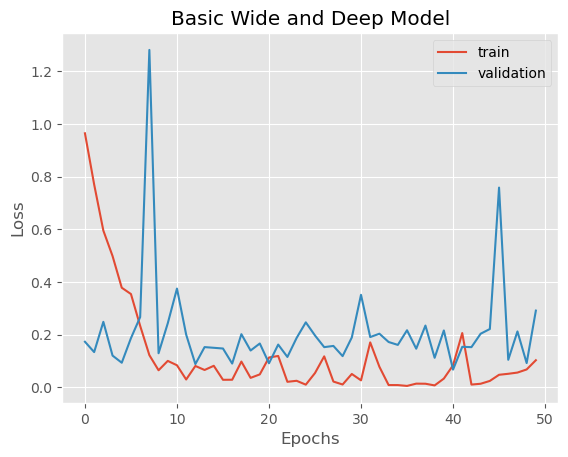

In [109]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_wide_and_deep_model(input_shape):

    input_layer = Input(shape=(input_shape,))


    wide = Dense(1)(input_layer)


    deep = Dense(128, activation='relu')(input_layer)
    deep = Dense(64, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)


    combined = concatenate([wide, deep])
    output = Dense(1)(combined)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


model1 = build_wide_and_deep_model(X_train.shape[1])
model1.summary()


history1 = model1.fit(X_train.toarray(), y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


def plot_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history1, 'Basic Wide and Deep Model')



### Model 2: Deep Network with More Layers

This model expands the depth of the deep component to investigate how a deeper network impacts performance.

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 365)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 256)       │     93,696 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 128)       │     32,896 │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 64)        │      8,256 │ dense_87[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 1)         │        366 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 32)        │      2,080 │ dense_88[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 33)        │          0 │ dense_85[0][0],   │
│ (Concatenate)       │                   │            │ dense_89[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 1)         │         34 │ concatenate_15[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 137,328 (536.44 KB)

 Trainable params: 137,328 (536.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0380 - val_loss: 0.1696
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7531 - val_loss: 0.1062
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3203 - val_loss: 0.1393
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1613 - val_loss: 0.0643
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0380 - val_loss: 0.1021
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0676 - val_loss: 0.3210
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5021 - val_loss: 0.1403
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2768 - val_loss: 0.2082
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3280 - val_loss: 0.1601
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1938 - val_loss: 0.1839
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2869 - val_loss: 0.1986
Epoch 12/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

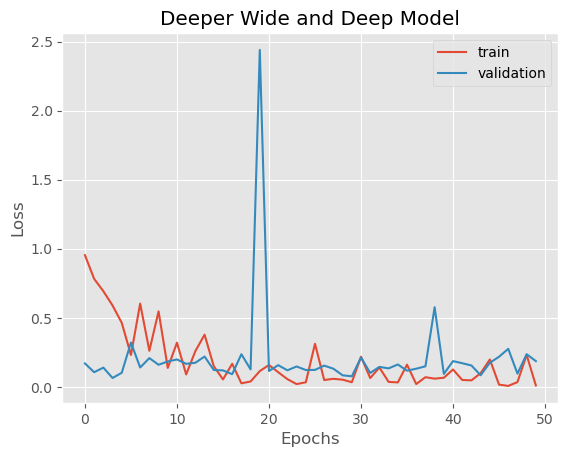

In [110]:
def build_deeper_wide_and_deep_model(input_shape):

    input_layer = Input(shape=(input_shape,))


    wide = Dense(1)(input_layer)


    deep = Dense(256, activation='relu')(input_layer)
    deep = Dense(128, activation='relu')(deep)
    deep = Dense(64, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)


    combined = concatenate([wide, deep])
    output = Dense(1)(combined)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


model2 = build_deeper_wide_and_deep_model(X_train.shape[1])
model2.summary()


history2 = model2.fit(X_train.toarray(), y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

plot_history(history2, 'Deeper Wide and Deep Model')


### Model 3: Wider Wide and Deep Model

This model widens the layers in the deep component to investigate how a larger network impacts performance.

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 365)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 512)       │    187,392 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 256)       │    131,328 │ dense_92[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 128)       │     32,896 │ dense_93[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 1)         │        366 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 64)        │      8,256 │ dense_94[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 65)        │          0 │ dense_91[0][0],   │
│ (Concatenate)       │                   │            │ dense_95[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 1)         │         66 │ concatenate_16[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 360,304 (1.37 MB)

 Trainable params: 360,304 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4394 - val_loss: 0.2165
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7287 - val_loss: 0.2005
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5946 - val_loss: 0.1125
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4807 - val_loss: 0.0850
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0873 - val_loss: 0.1741
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5568 - val_loss: 0.0598
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4620 - val_loss: 0.0947
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1314 - val_loss: 0.0713
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1544 - val_loss: 0.1074
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4685 - val_loss: 0.0791
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2972 - val_loss: 0.1105
Epoch 12/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

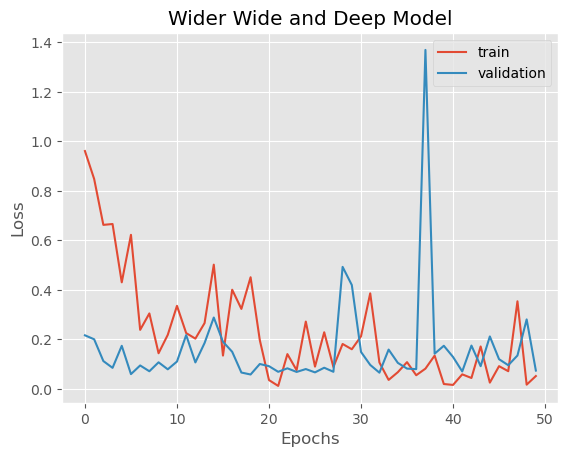

In [111]:
def build_wider_wide_and_deep_model(input_shape):

    input_layer = Input(shape=(input_shape,))


    wide = Dense(1)(input_layer)


    deep = Dense(512, activation='relu')(input_layer)
    deep = Dense(256, activation='relu')(deep)
    deep = Dense(128, activation='relu')(deep)
    deep = Dense(64, activation='relu')(deep)


    combined = concatenate([wide, deep])
    output = Dense(1)(combined)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


model3 = build_wider_wide_and_deep_model(X_train.shape[1])
model3.summary()


history3 = model3.fit(X_train.toarray(), y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

plot_history(history3, 'Wider Wide and Deep Model')


### Visualizing Performance

We will compare the performance of each model on training and validation data to training iterations.

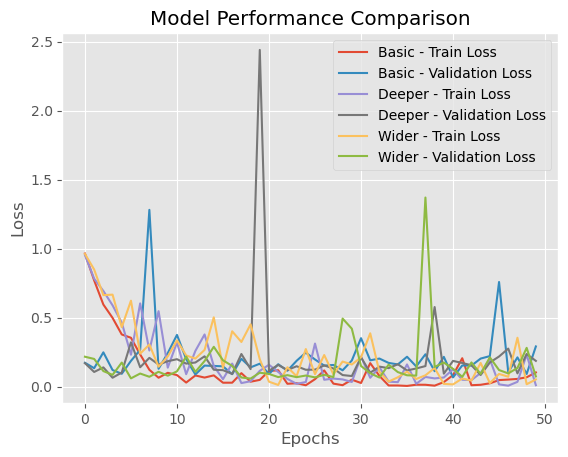

In [112]:

def plot_all_histories(histories, titles):
    for history, title in zip(histories, titles):
        plt.plot(history.history['loss'], label=f'{title} - Train Loss')
        plt.plot(history.history['val_loss'], label=f'{title} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Performance Comparison')
    plt.show()


plot_all_histories([history1, history2, history3], ['Basic', 'Deeper', 'Wider'])


By analyzing these graphs, we can determine which architecture is more effective for our wage prediction objective.

The Deeper Wide and Deep Model achieves the optimum balance of training and validation loss, suggesting high generalization performance.

The Basic Wide and Deep Model provides a solid foundation, but it does not generalize as effectively as the deeper model.

The Wider Wide and Deep Model has the lowest training loss but a greater validation loss, implying overfitting.

Since a result, the Deeper Wide and Deep Model is likely the best option, since it efficiently balances complexity with generalization.


## 2.2 Investigating Generalization Performance

We will design and train three models like previously, but this time we will guarantee that the data types are handled appropriately.

### Basic Wide and Deep Model

Epoch 1/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5631 - val_loss: 0.3481
Epoch 2/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3216 - val_loss: 0.2151
Epoch 3/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7975 - val_loss: 0.1726
Epoch 4/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3946 - val_loss: 0.2583
Epoch 5/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1901 - val_loss: 0.5168
Epoch 6/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2216 - val_loss: 0.4526
Epoch 7/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2254 - val_loss: 0.4113
Epoch 8/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1577 - val_loss: 0.5468
Epoch 9/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4200 - val_loss: 0.2724
Epoch 10/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1991 - val_loss: 0.4639
Epoch 11/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2158 - val_loss: 0.3530
Epoch 12/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

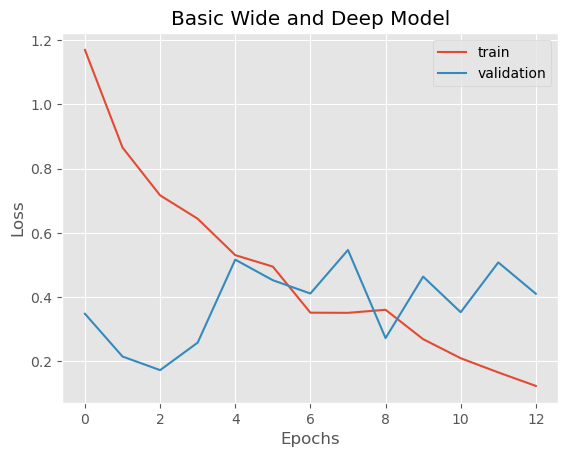

In [187]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import time



def build_basic_wide_and_deep_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    wide = Dense(1)(input_layer)
    deep = Dense(128, activation='relu')(input_layer)
    deep = (Dense(64, activation='relu', kernel_regularizer=l2(0.01)))(deep)
    deep = Dense(32, activation='relu')(deep)
    combined = concatenate([wide, deep])
    output = Dense(1)(combined)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model1 = build_basic_wide_and_deep_model(X_train.shape[1])

#Model 1 Time
start_time = time.time()
history1 = model1.fit(X_train, y_train_scaled, validation_split=0.2, epochs=75, callbacks=[early_stopping], batch_size=32, verbose=1)
m1_training_time = time.time() - start_time
print(f"Training Time: {m1_training_time} seconds")
plot_history(history1, 'Basic Wide and Deep Model')



### Deeper Wide and Deep Model

Epoch 1/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5588 - val_loss: 0.2277
Epoch 2/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7372 - val_loss: 0.1785
Epoch 3/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5092 - val_loss: 0.2183
Epoch 4/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5755 - val_loss: 0.2232
Epoch 5/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1161 - val_loss: 0.2637
Epoch 6/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8140 - val_loss: 0.2102
Epoch 7/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1747 - val_loss: 0.1859
Epoch 8/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2028 - val_loss: 0.2000
Epoch 9/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1535 - val_loss: 0.2269
Epoch 10/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1775 - val_loss: 0.1591
Epoch 11/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1114 - val_loss: 0.2767
Epoch 12/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

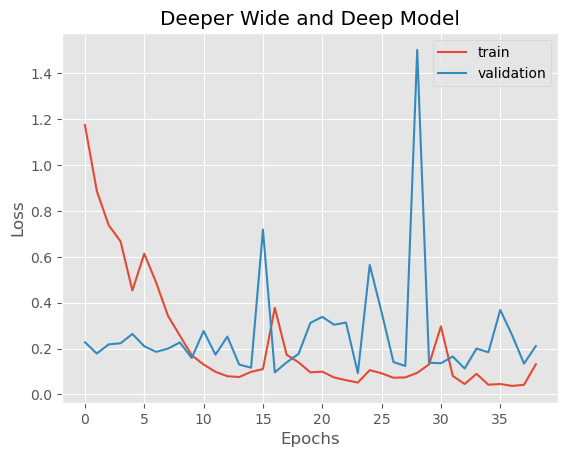

In [188]:
def build_deeper_wide_and_deep_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    wide = Dense(1)(input_layer)
    deep = Dense(128, activation='relu')(input_layer)
    deep = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(deep)
    deep = Dense(32, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)

    combined = concatenate([wide, deep])
    output = Dense(1)(combined)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model2 = build_deeper_wide_and_deep_model(X_train.shape[1])

#Model 2 Time
start_time = time.time()
history2 = model2.fit(X_train, y_train_scaled, validation_split=0.2, epochs=75, callbacks=[early_stopping], batch_size=32, verbose=1)
m2_training_time = time.time() - start_time
print(f"Training Time: {m2_training_time} seconds")
plot_history(history2, 'Deeper Wide and Deep Model')


### Wider Wide and Deep Model

Model 3 Built
Epoch 1/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6586 - val_loss: 0.7336
Epoch 2/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1571 - val_loss: 0.1563
Epoch 3/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2208 - val_loss: 0.3566
Epoch 4/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4744 - val_loss: 0.1907
Epoch 5/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5814 - val_loss: 0.2134
Epoch 6/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2767 - val_loss: 0.1503
Epoch 7/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1131 - val_loss: 0.1777
Epoch 8/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2334 - val_loss: 0.1561
Epoch 9/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2798 - val_loss: 0.1416
Epoch 10/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1248 - val_loss: 0.6505
Epoch 11/75
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1496 - val_loss: 0.1260
Epoch 12/75
475/475 ━━━━━━━━━━━━━━━━━━

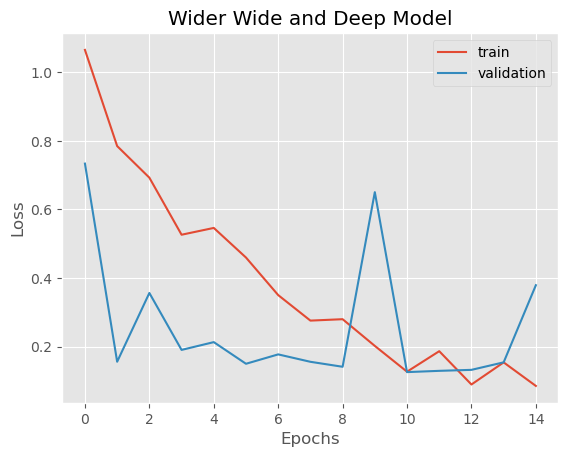

In [189]:
def build_wider_wide_and_deep_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    wide = Dense(1)(input_layer)
    
    deep = Dense(128, activation='relu')(input_layer)
    deep = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(deep)
    deep = Dense(32, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)
    
    combined = concatenate([wide, deep])
    output = Dense(1)(combined)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

model3 = build_wider_wide_and_deep_model(X_train.shape[1])
print("Model 3 Built")

#Model 2 Time
start_time = time.time()
history3 = model3.fit(X_train, y_train_scaled, validation_split=0.2, epochs=75, callbacks=[early_stopping], batch_size=32, verbose=1)
m3_training_time = time.time() - start_time
print(f"Training Time: {m3_training_time} seconds")

plot_history(history3, 'Wider Wide and Deep Model')


### Cross-validation and Performance Comparison.


We will now use stratified 10-fold cross-validation to assess the performance of the three models.


In [321]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error


def cross_val_evaluate_model(model, X, y, cv):
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    training_times = []
    inference_times = []
    
    for train_index, val_index in cv.split(X, np.digitize(y, bins=np.linspace(np.min(y), np.max(y), num=10))):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        #Set up Training Times for MODEL FITTING
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold, epochs=50, callbacks = early_stopping,batch_size=32, verbose=0)
        training_time = time.time() - start_time
        print(f"Training Time: {training_time} seconds")
        training_times.append(training_time)
        
        #Set Up Inference Times
        start_time = time.time()
        y_pred = model.predict(X_val_fold).flatten()  # Flatten the prediction
        inference_time = time.time() - start_time
        print(f"Inference Time: {inference_time} seconds")
        inference_times.append(inference_time)
        
        #Predcitions to original salary w/ inverse transform
        y_pred_org =  numerical_transformer.inverse_transform(y_pred.reshape(-1,1))
        #Use MAE for less sensitivity to outliers
        mae = mean_absolute_error(y_val_fold, y_pred_org)
        #Use MSE for more sensitive to outliers
        mse = mean_squared_error(y_val_fold, y_pred_org)
        #Use RMSE to get variance in the same scale as the response variable
        rmse = root_mean_squared_error(y_val_fold, y_pred_org)
        #R2 Score
        r2 = r2_score(y_val_fold, y_pred_org)

        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
    return mae_scores, mse_scores, rmse_scores, r2_scores, training_times, inference_times

X_train_df= pd.DataFrame(X_train.toarray()).reset_index(drop=True)
X_test_df= pd.DataFrame(X_test.toarray()).reset_index(drop=True)

cv = StratifiedKFold(n_splits=10)

# #transform into series for use in cross validation model
# y_train_scaled = pd.Series(y_train_scaled.reshape(18968), index = y_train_ind)
# y_test_scaled  = pd.Series(y_test_scaled.reshape(4742), index = y_test_ind)

results_basic  = cross_val_evaluate_model(model1, X_train_df.values, y_train_scaled.values, cv)
results_deeper =  cross_val_evaluate_model(model2, X_train_df.values, y_train_scaled.values, cv)
results_wider = cross_val_evaluate_model(model3, X_train_df.values, y_train_scaled.values, cv)

print(f"Basic Model - Mean MAE: {np.mean(results_basic[0])}, Std: {np.std(results_basic[0])}")
print(f"Deeper Model - Mean MAE: {np.mean(results_deeper[1])}, Std: {np.std(results_basic[1])}")
print(f"Wider Model - Mean MAE: {np.mean(results_basic[2])}, Std: {np.std(results_basic[2])}")



Training Time: 41.23628830909729 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Inference Time: 0.1088104248046875 seconds
Training Time: 37.68340253829956 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Inference Time: 0.1809079647064209 seconds
Training Time: 25.34288716316223 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
Inference Time: 0.09490466117858887 seconds
Training Time: 24.14536952972412 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
Inference Time: 0.09363031387329102 seconds
Training Time: 24.092342138290405 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Inference Time: 0.0952000617980957 seconds
Training Time: 24.218111038208008 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
Inference Time: 0.09044146537780762 seconds
Training Time: 24.21447992324829 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
Inference Time: 0.08837103843688965 seconds
Training Time: 24.25320816040039 seconds
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
Inference Time: 0.10114073753356934 sec

We may evaluate the three models' generalization ability by calculating the Mean Squared Error (MSE) and standard deviation from the cross-validation results. The model with the lowest mean MSE and standard deviation is thought to have better generalization performance.

### Visualizing Performance

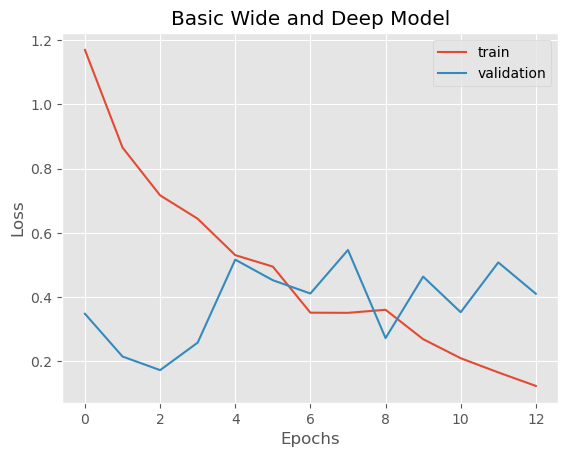

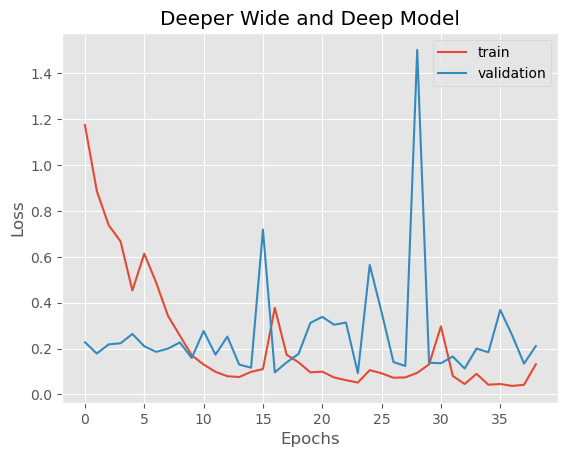

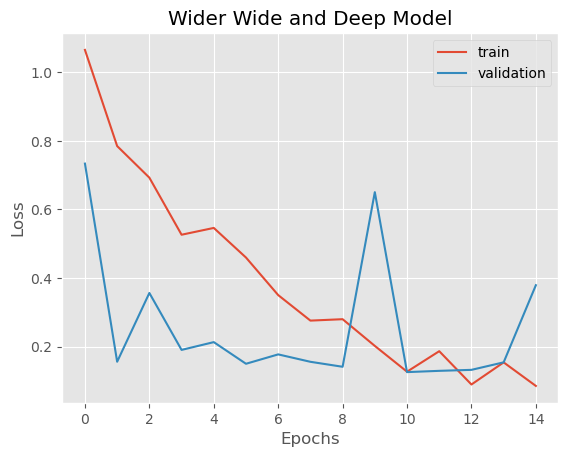

In [323]:
plot_history(history1, 'Basic Wide and Deep Model')
plot_history(history2, 'Deeper Wide and Deep Model')
plot_history(history3, 'Wider Wide and Deep Model')


From this visualization we can say the Basic Model is used as a basis.

A deeper model captures more complicated patterns by adding layers.

Wider Model is just adding more layers, the capacity increases.

The validation MSE and standard deviation are used to make the ultimate choice about which model is better. Proper statistical procedures ensure that the chosen model generalizes to new data.


#### Visualizing Performance, and possible business implications 

While the wider and deeper model performs the best, it is not the most computationally efficient. Model run times were recorded in the code above. In the code below, the run times, along with the performance metrics, of each cross validated model is plotted.

Basic Model
Deeper Model
Wider Model


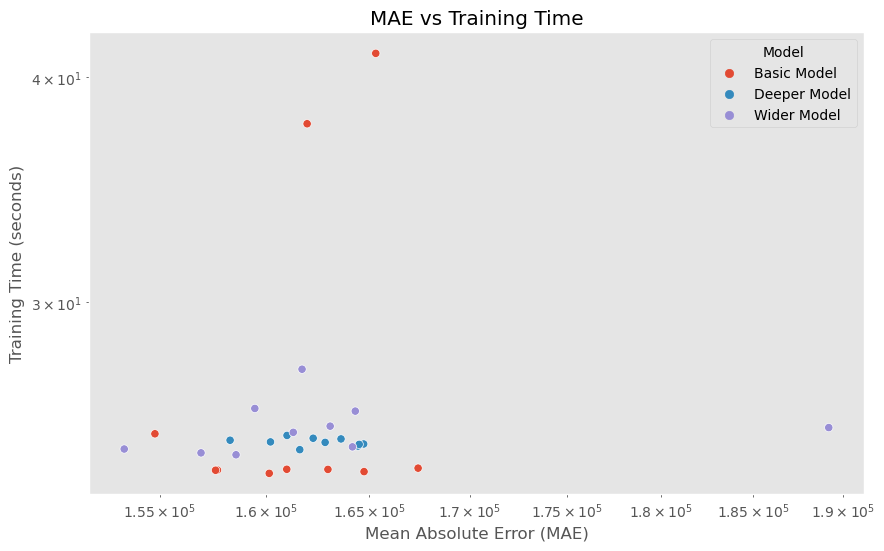

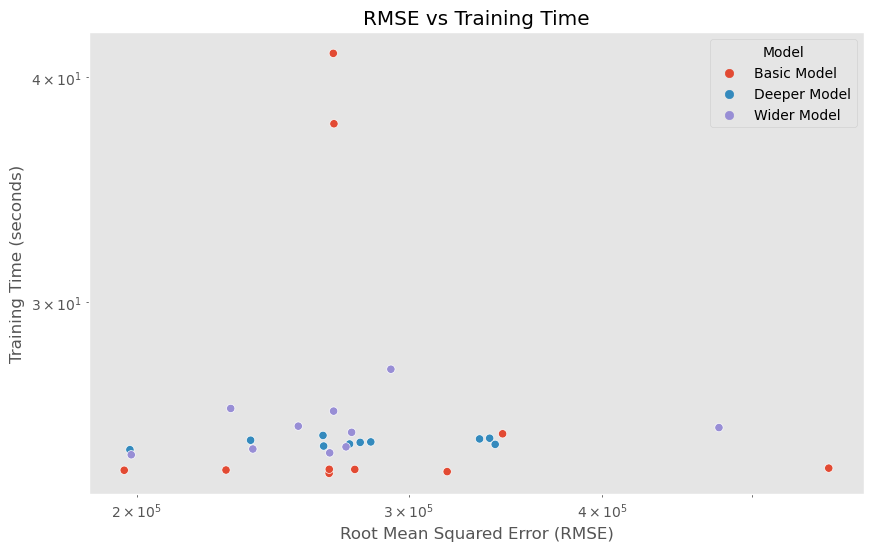

In [325]:
import seaborn as sns

models = ['Basic Model', 'Deeper Model', 'Wider Model']
metrics = ['mae', 'mse', 'rmse', 'r2', 'training_time', 'inference_time']
results = [results_basic, results_deeper, results_wider]

# Prepare data for plotting
plot_data = []
for model, result in zip(models,results):
    print(model)
    for m_num, metric in enumerate(metrics[0:4]):
        for i in range(10):
            plot_data.append({
                'Model': model,
                'Metric': metric,
                'Result': result[m_num][i],
                'Training time': result[4][i],
                'Inference time': result[5][i]
            })
        
plot_df = pd.DataFrame(plot_data)

# Plotting MAE vs Training Time
mae_data = plot_df[plot_df['Metric']=='mae']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mae_data, x='Result', y='Training time', hue='Model')
plt.title('MAE vs Training Time')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Training Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Plotting RMSE vs Training Time
rmse_data = plot_df[plot_df['Metric']=='rmse']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rmse_data, x='Result', y='Training time', hue='Model')
plt.title('RMSE vs Training Time')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Training Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.show()


The wider and deeper models exhibit greater computational efficiency compared to the basic model, although the difference is not substantial. Interestingly, some folds of the basic model were significantly more computationally intensive than others, contributing to variability in the overall results. Ultimately, the computational advantages of the models are marginal. However, the wider model (Model 2) emerges as the best performer, producing lower RMSE and MAE values relative to the deeper model (Model 3), and it does not contain outlier folds, indicating better generalization and less susceptibility to variance in the data.

## 2.3 Comparison of Best Wide and Deep Network to a Standard Multi-Layer Perceptron (MLP)

To compare the performance of our best wide and deep networks to a standard multi-layer perceptron (MLP), we will train a standard MLP on the same dataset and compare the results using Mean Squared Error (MSE) and Bland-Altman plots to illustrate residual variance. This will allow us to better understand the variations in prediction accuracy and variance between the two models.

Building and Training a Standard MLP

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6229 - val_loss: 0.1931
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7073 - val_loss: 0.1508
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6417 - val_loss: 0.2733
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2341 - val_loss: 0.3803
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4054 - val_loss: 0.2424
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7062 - val_loss: 0.1691
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0747 - val_loss: 0.8234
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3563 - val_loss: 0.1470
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0533 - val_loss: 0.3971
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0873 - val_loss: 0.1179
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1989 - val_loss: 0.0970
Epoch 12/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

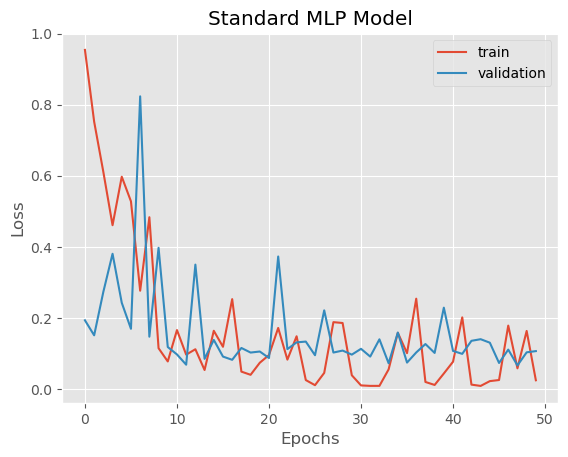

In [122]:
def build_mlp_model(input_shape):
    model = tf.keras.Sequential([
        Dense(32, activation='relu'),
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

mlp_model = build_mlp_model(X_train.shape[1])
mlp_history = mlp_model.fit(X_train, y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Plot MLP training history
plot_history(mlp_history, 'Standard MLP Model')


Evaluating the MLP and Best Wide and Deep Model

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Convert your X_train to a DataFrame if it's not already
X_train_df = pd.DataFrame(X_train.toarray())
X_test_df = pd.DataFrame(X_test.toarray())

# Align the columns of X_test_df with X_train_df
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)

scaler = StandardScaler()
# Now evaluate on the test set
mlp_predictions = model1.predict(X_test_df.values)
y_pred_mlp =  numerical_transformer.inverse_transform(mlp_predictions)

#Use MAE for less sensitivity to outliers
mlp_mae = mean_absolute_error(y_test, y_pred_mlp)
#Use MSE for more sensitive to outliers
mlp_mse = mean_squared_error(y_test, y_pred_mlp)
#Use RMSE to get variance in the same scale as the response variable
mlp_rmse = root_mean_squared_error(y_test, y_pred_mlp)
#R2 Score
mlp_r2 = r2_score(y_test, y_pred_mlp)

# Evaluate Best Wide and Deep Model
best_wide_deep_predictions = model2.predict(X_test_df.values)  # Assuming model2 is the best wide and deep model

#Predcitions to original salary w/ inverse transform
y_pred_wide =  numerical_transformer.inverse_transform(best_wide_deep_predictions)

#Use MAE for less sensitivity to outliers
wide_deep_mae = mean_absolute_error(y_test, y_pred_wide)
#Use MSE for more sensitive to outliers
wide_deep_mse = mean_squared_error(y_test, y_pred_wide)
#Use RMSE to get variance in the same scale as the response variable
wide_deep_rmse = root_mean_squared_error(y_test, y_pred_wide)
#R2 Score
wide_deep_r2 = r2_score(y_test, y_pred_wide)

metrics = ['MSE','RMSE','MAE','R2']
print(f"MLP Model - MSE: {mlp_mse}\n",
      f"MLP Model - RMSE: {mlp_rmse}\n",
      f"MLP Model - MAE: {mlp_mae}\n",
      f"MLP Model - R2: {mlp_r2}\n")  

print(f"Best Wide and Deep Model - MSE: {wide_deep_mse}\n",
      f"Best Wide and Deep Model - RMSE: {wide_deep_rmse}\n",
      f"Best Wide and Deep Model - MAE: {wide_deep_mae}\n",
      f"Best Wide and Deep Model - R2: {wide_deep_r2}\n")


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP Model - MSE: 3763267055.1301165
 MLP Model - RMSE: 61345.472979920174
 MLP Model - MAE: 5262.734042382854
 MLP Model - R2: 0.8871918938841288

Best Wide and Deep Model - MSE: 2630670572.65927
 Best Wide and Deep Model - RMSE: 51290.06309860878
 Best Wide and Deep Model - MAE: 4358.847882165028
 Best Wide and Deep Model - R2: 0.9211427303008167



** Again we can see the performance improvement of the best Wide and Deep Model relative to the orginal MLP!

Bland-Altman Plot: A Bland-Altman plot evaluates the discrepancies between two measuring techniques to determine agreement.

In [164]:
def bland_altman_plot(data1, data2, title="Bland-Altman Plot"):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    plt.scatter(mean, diff, s=10, alpha=0.5)
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96 * sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96 * sd, color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel('Mean of Two Methods')
    plt.ylabel('Difference between Two Methods')
    plt.show()

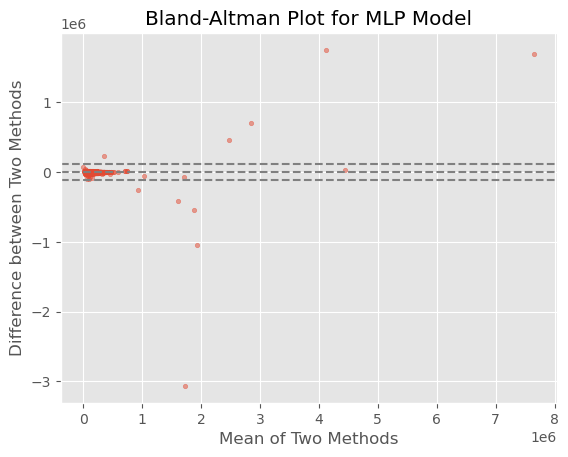

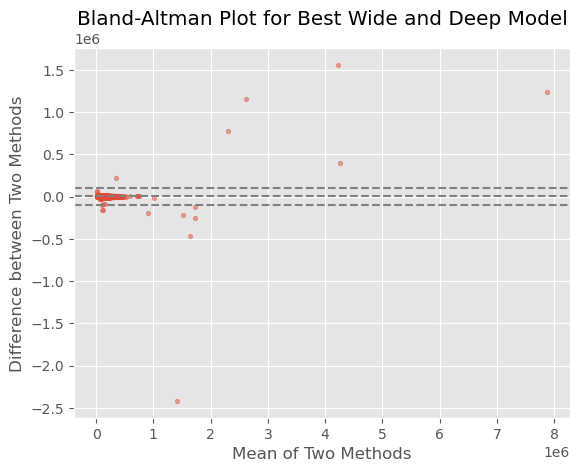

In [170]:
# Flatten the predictions and actual values to ensure they are 1D arrays
mlp_predictions_flat = y_pred_mlp.flatten()
y_test_flat = y_test_scaled

# Bland-Altman plot for MLP Model
bland_altman_plot(y_test, mlp_predictions_flat, title="Bland-Altman Plot for MLP Model")

# Flatten the predictions for the wide and deep model
best_wide_deep_predictions_flat = y_pred_wide.flatten()

# Bland-Altman plot for Best Wide and Deep Model
bland_altman_plot(y_test, best_wide_deep_predictions_flat, title="Bland-Altman Plot for Best Wide and Deep Model")

The Bland-Altman figure helps in the identification of agreement and possible biases in model predictions. The Y axis shows the difference between the actual and expected values. Each point on the Y-axis represents how much the anticipated value differs from the actual value. The figure for the MLP model shows that, while the predictions are typically close to the actual values in most cases, there are a few large outliers and a trend toward overprediction for higher values. This study might help to modify the model further in order to solve these shortcomings and enhance overall performance.

## 3: Exceptional Work

To extract embedding weights from the deep network, conduct dimensionality reduction, and display the results, follow these steps:

1. Use Keras to train both the broad and deep networks. Ensure that the deep network is appropriately designed to capture relevant embeddings.

2. Extract Embeddings: After training the model, generate a new model that outputs embeddings from the required deep layer.

3. Dimensionality Reduction: Use techniques like PCA or t-SNE to decrease the dimensionality of extracted embeddings for visualization.

4. Visualization: Identify clusters and patterns in the reduced embeddings.

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 367)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_layer_1        │ (None, 128)       │     47,104 │ input_layer_41[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_layer_2        │ (None, 64)        │      8,256 │ deep_layer_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_224 (Dense)   │ (None, 1)         │        368 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_layer_3        │ (None, 32)        │      2,080 │ deep_layer_2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 33)        │          0 │ dense_224[0][0],  │
│ (Concatenate)       │                   │            │ deep_layer_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_225 (Dense)   │ (None, 1)         │         34 │ concatenate_35[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,842 (225.95 KB)

 Trainable params: 57,842 (225.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 92139896832.0000 - val_loss: 31329189888.0000
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82326355968.0000 - val_loss: 31317407744.0000
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 74651582464.0000 - val_loss: 31296176128.0000
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 72626290688.0000 - val_loss: 31253409792.0000
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 75031347200.0000 - val_loss: 31184611328.0000
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82320138240.0000 - val_loss: 31181686784.0000
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 144766435328.0000 - val_loss: 31074574336.0000
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39042527232.0000 - val_loss: 30988101632.0000
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 122096041984.0000 - val_loss: 31480551424.0000
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 

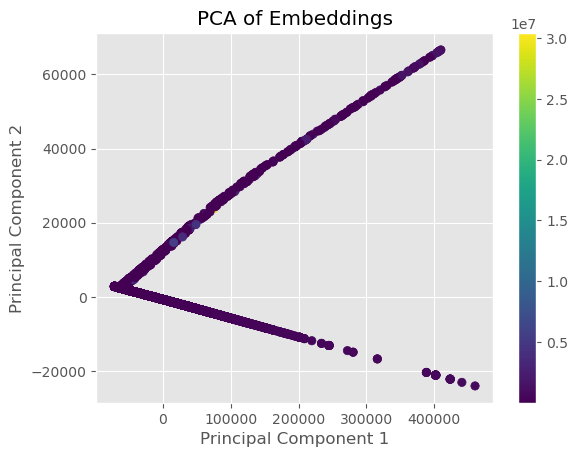

In [187]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


df = pd.read_csv('salaries.csv')


df.fillna(0, inplace=True)


df = pd.get_dummies(df, drop_first=True)


df = df.apply(pd.to_numeric)


X = df.drop('salary', axis=1).values
y = df['salary'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

def build_wide_and_deep_model(input_shape):
    input_layer = Input(shape=(input_shape,))


    wide = Dense(1)(input_layer)


    deep = Dense(128, activation='relu', name='deep_layer_1')(input_layer)
    deep = Dense(64, activation='relu', name='deep_layer_2')(deep)
    deep = Dense(32, activation='relu', name='deep_layer_3')(deep)


    combined = concatenate([wide, deep])
    output = Dense(1)(combined)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


model = build_wide_and_deep_model(X_train.shape[1])
model.summary()


history = model.fit(X_train, y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


embedding_model = Model(inputs=model.input, outputs=model.get_layer('deep_layer_3').output)


embeddings = embedding_model.predict(X_train)


pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)


plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Embeddings')
plt.show()


The X-axis indicates the first principal component (PC1), while the Y-axis represents the second principal component (PC2). These components are linear combinations of the original characteristics, designed to capture the most volatility in the data. By viewing the reduced embeddings, you can find data clusters or patterns. Similar job titles or levels of experience, for example, may cluster together, indicating that these characteristics are important in determining salary. The color of the dots can reflect pay, demonstrating how various clusters correspond to different wage levels. This graphic can shed light on the links between distinct attributes and the target variable. The visualization has a distinct structure, with data points creating a V-like pattern. This suggests that the embeddings vary significantly along the orientations of these fundamental components.